In [1]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Sigma1 = np.array([[1, 0], [0, 1]])
# mu1 = np.array([1, 1])
# Sigma2 = np.array([[6, 0], [0, 6]])
# mu2 = np.array([6, 6])

In [3]:
# Sigma1 = np.array([[3, 0], [0, 3]])
# mu1 = np.array([3, 5])
# Sigma2 = np.array([[1, 0], [0, 1]])
# mu2 = np.array([10, 5])

In [4]:
# from sklearn.datasets import make_blobs

# n_samples = 300
# n_cls = 2

# X,y = make_blobs( 
#         n_samples=n_samples,
#         centers=[mu1, mu2],  
#         cluster_std=[1, 2.45]#[[3, 3], [1, 1]]
#     )


# lmbd = [ 1.1, ]*n_cls  # коэффициент "цены" ошибки

# X.shape, y.shape

In [165]:
n_samples = 300
n_cls = 2

mean1 = [1, 1]
cov1 = [[1, 0], [0, 1]]
mean2 = [6, 6]
cov2 = [[3, 0], [0, 3]]

# cov1 = np.array([[3, 0], [0, 3]])
# mean1 = np.array([3, 5])
# cov2 = np.array([[1, 0], [0, 1]])
# mean2 = np.array([10, 5])

X1 = np.random.multivariate_normal(mean1, cov1, n_samples)
y1 = np.zeros(X1.shape[0]).astype(int)

X2 = np.random.multivariate_normal(mean2, cov2, n_samples)
y2 = np.ones(X2.shape[0]).astype(int)

X = np.vstack([X1, X2])
y = np.hstack([y1, y2])

lmbd = [ 1.1, ]*n_cls  # коэффициент "цены" ошибки

X.shape, y.shape

((600, 2), (600,))

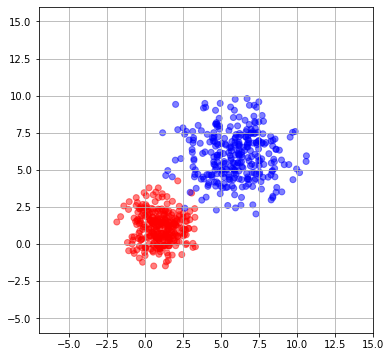

In [166]:
plt.figure(figsize=(6, 6))
plt.xlim(-7, 15)
plt.ylim(-6, 16)
plt.scatter(X[:,0], X[:,1], c = [['r','b','g','y'][j] for j in y], alpha=0.5 )   
plt.grid()
plt.show()

In [167]:
from sklearn.naive_bayes import GaussianNB

In [168]:
clf = GaussianNB().fit(X, y)

In [169]:
y_pred = clf.predict(X)

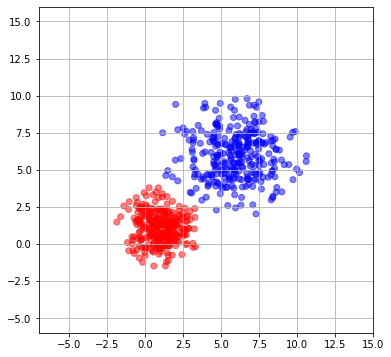

In [170]:
plt.figure(figsize=(6, 6))
plt.xlim(-7, 15)
plt.ylim(-6, 16)
plt.scatter(X[:,0], X[:,1], c = [['r','b','g','y'][j] for j in y_pred], alpha=0.5 )   
plt.grid()
plt.show()

In [171]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, )

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((300, 2), (300,), (300, 2), (300,))

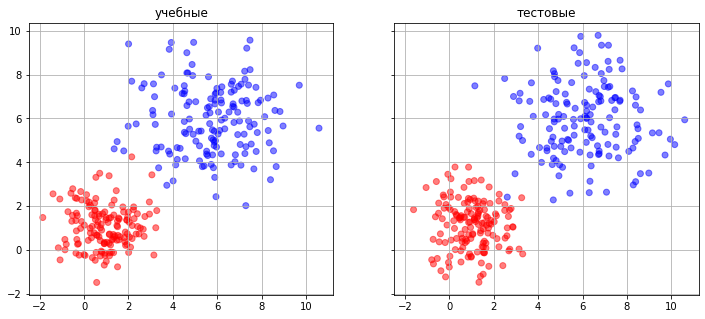

In [172]:
def plot_data(ax,X,y,t, marker='o'):
    c = [ ['r','b','g','y'][j] for j in y  ]
    ax.set_title(t)
    ax.scatter( x=X[:,0], y=X[:,1], c=c,  alpha=0.5, marker=marker )
    ax.grid()

fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_train,y_train,'учебные')    
plot_data(ax1,X_test,y_test,'тестовые')    
plt.show()

In [173]:
def K(x): return (1.0 - x**2) * 0.75

In [174]:
def K(x): return 0.5 * (abs(x) < 1)

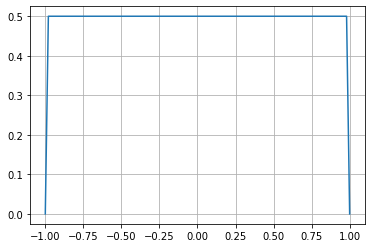

In [175]:
x = np.linspace(-1,1,100)
plt.plot(x,K(x))
plt.grid()
plt.show()

In [176]:
# евклидова метрика
def rho(x1,x2): return np.sqrt(np.square(x1-x2).sum(axis=1))

$ a(x) = \underset{y\in Y}{\operatorname{argmax}} \left[ \lambda_y P_y \frac{1}{l_y} \underset{i:y=y_i}{\sum} K\left(\frac{\rho(x-x_i)}{h}\right) \right] $

In [177]:
def bayes_score(X,Xl,yl,lmbd_n,h,n,Py_n,ly_n): # скор принадлежности X к классу n
    # Xl,yl - учебный набор
    # Py_n - априорная вероятность класса n
    # ly_n - количество объектов в классе n
    # lmbd_n - цена ошибки класса n
    # h - ширина парзеновского окна
    
    Xn = Xl[yl==n,:] # точки класса n

    # для каждой точки набора X
    # считаем растояние до всех точек учебного класса
    r = np.asarray([ rho(X[i,:],Xn) for i in range(X.shape[0]) ]) 
    
    # применяем ядро и суммируем
    r = K( r / h).sum(axis=1)

    return ( Py_n * lmbd_n / ly_n ) * r

In [178]:
def bayes(X,Xl,yl,lmbd,h): # байесовский классификатор
    # для кажной точки набора X 
    # хаходим номер класса с наибольшим скором
    # Xl,yl - учебный набор
    # lmbd - цена ошибки классов    
    # h - ширина окна
    
    # количество объектов в классах
    ly = np.asarray([ (yl==c).sum() for c in sorted(set(yl)) ])
    Py = ly/ly.sum() # априорные вероятности классов
    
    return np.argmax( 
        np.asarray([ 
            bayes_score(X,Xl,yl,lmbd[n],h,n,Py[n],ly[n])  
            for n in sorted(set(yl)) 
        ]),
        axis=0 )

In [231]:
def bayes(xi,Xl,yl,lmbd,h):
    clf = MyNaiveBayes().fit(Xl, yl, lmbd, h)
    return clf.predict(xi)

In [232]:
# LOO ( leave one out) - скользящий контроль,
# выбираем объект учебного набора X,y
# удаляем его из набора
# выполняем его классификацию и проверяем ответ
def loo(X,y,lmbd,h):
    er = 0 # количество ошибок
    for i in range(X.shape[0]):
        xi,yi = X[i,:].reshape(1,X.shape[1]),y[i] # выбираем объект учебного набора
        # удаляем его из набора
        Xl,yl = np.delete(X, i, axis=0), np.delete(y, i, axis=0)
        er += int(bayes(xi,Xl,yl,lmbd,h) != yi) #/ yl.shape[0] # выполняем классификацию и проверяем ответ

    return er

In [233]:
# подбираем параметр ширины парзеновского окна 
er = []
h = np.arange(1, 6, 0.1)
for hi in h:
    er.append(loo(X_train,y_train,lmbd,hi))
h = np.round(h[np.argmin(er)], 3)

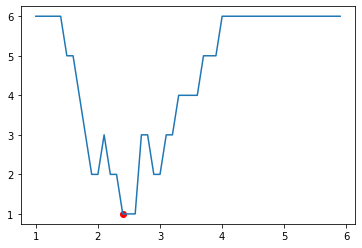

In [234]:
plt.plot(np.arange(1, 6, 0.1), er)
plt.scatter(h, np.min(er), c='r', marker='o')

In [235]:
h

2.4

In [236]:

class MyNaiveBayes:
    
    def __init__(self):
        self.yl = []
        pass
    
    def fit(self, X_train, y_train, lmbd, h):
        self.X_train = X_train
        self.y_train = y_train
        self.yl = sorted(set(y_train))
        self.lmbd = lmbd
        self.h = h
        # количество объектов в классах
        self.ly = np.asarray([(y_train==c).sum() for c in self.yl])
        # априорные вероятности классов
        self.Py = self.ly / self.ly.sum() 

        return self
    
    def predict(self, X_test):
        res = []
        for n in self.yl:
            Xn = self.X_train[self.y_train==n,:]
            r = np.asarray([rho(X_test[i,:], Xn) for i in range(X_test.shape[0])])
            r = K(r / self.h).sum(axis=1)
            res.append((self.Py[n] * self.lmbd[n] / self.ly[n]) * r )
        return np.argmax(np.asarray(res), axis=0)
        

In [237]:
clf = MyNaiveBayes().fit(X_train, y_train, lmbd, h)

y_pred = clf.predict(X_test)

In [238]:
y_pred

array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0], d

In [239]:
# o = bayes(X_test,X_train,y_train,lmbd,h)
# o.shape

In [240]:
xlim = (-2.5, 17.5)
ylim = (-4, 15)
dist = 0.4

In [241]:
x2, y2 = np.meshgrid(np.linspace(xlim[0], xlim[1], round(xlim[1] - xlim[0] / dist)), np.linspace(ylim[0], ylim[1], round(ylim[1] - ylim[0] / dist)))
X_grid = np.hstack([x2.reshape(-1, 1), y2.reshape(-1, 1)])

In [242]:
y_grid = clf.predict(X_grid)

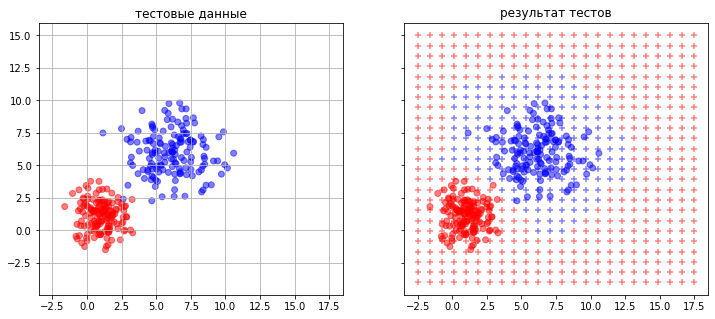

In [243]:
fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_test,y_test,'тестовые данные')    
plot_data(ax1,X_test,y_pred,'результат тестов')  
plot_data(ax1,X_grid,y_grid,'результат тестов', marker='+')    
plt.show()

In [191]:
# def nbayes_score(X,Xl,yl,lmbd_n,h,n,Py_n,ly_n): # скор принадлежности X к классу n
#     # Xl,yl - учебный набор
#     # Py_n - априорная вероятность класса n
#     # ly_n - количество объектов в классе n
#     # lmbd_n - цена ошибки класса n
#     # h - ширина парзеновского окна
    
#     Xn = Xl[yl==n,:] # точки класса n
    
#     m = Xn.shape[0]
    
#     myj = (1 / m * np.sum(Xn, axis=0))#.reshape(-1, 1)
#     print('mu' + str(n) + ' = ' + str(myj))
#     syj = (1/Xn.shape[0] * np.sum(np.square(Xn - myj), axis = 0))#.reshape(-1, 1)
#     print('sigma' + str(n) + ' = ' + str(syj))
    
    
#     r = (1 / (np.sqrt(2 * np.pi) * syj)) * np.exp(((X - myj) ** 2) / (2 * syj ** 2))
#     r = r.sum(axis=1)

#     return ( Py_n * lmbd_n ) * r

In [192]:
# def nbayes(X,Xl,yl,lmbd,h): # байесовский классификатор
#     # для кажной точки набора X 
#     # хаходим номер класса с наибольшим скором
#     # Xl,yl - учебный набор
#     # lmbd - цена ошибки классов    
#     # h - ширина окна
    
#     # количество объектов в классах
#     ly = np.asarray([ (yl==c).sum() for c in sorted(set(yl)) ])
#     Py = ly/ly.sum() # априорные вероятности классов
    
#     return np.argmax( 
#         np.asarray([ 
#             nbayes_score(X,Xl,yl,lmbd[n],h,n,Py[n],ly[n])  
#             for n in sorted(set(yl)) 
#         ]),
#         axis=0 )

In [193]:
# nn = nbayes(X_test,X_train,y_train,lmbd,h)
# nn.shape

In [194]:
# евклидова метрика
def rho(x1,x2): return np.sqrt(np.square(x1 - x2).sum(axis=1))

In [244]:

class MyNormNaiveBayes:
    
    def __init__(self):
        self.myj = []
        self.syj = []
        self.yl = []
        pass
    
    def fit(self, X_train, y_train, lmbd):
        self.yl = sorted(set(y_train))
        self.lmbd = lmbd
        # количество объектов в классах
        self.ly = np.asarray([(y_train==c).sum() for c in self.yl])
        # априорные вероятности классов
        self.Py = self.ly / self.ly.sum() 
        for n in self.yl:
            Xn = X_train[y_train==n,:] # точки класса n
            m = Xn.shape[0]
            
            myj = 1 / m * np.sum(Xn, axis=0)
            self.myj.append(myj)
            syj = 1 / Xn.shape[0] * np.sum(np.square(Xn - myj), axis = 0)
            self.syj.append(syj)
        return self
    
    def predict(self, X_test):
        res = []
        

        for n in self.yl:
            r = 1 / (np.sqrt(2 * np.pi) * self.syj[n]) * \
                np.exp(-0.5 * ((X_test - self.myj[n]) / self.syj[n]) ** 2)
#             r = np.zeros_like(X_test)
#             for j in range(X_test.shape[1]):
#                 r[:, j] = 1 / (np.sqrt(2 * np.pi) * self.syj[n][j]) * \
#                           np.exp(-0.5 * ((X_test[:, j] - self.myj[n][j]) / self.syj[n][j]) ** 2)
            r = np.log(r).sum(axis=1)
            res.append(self.Py[n] * self.lmbd[n] * r)
        return np.argmax(np.asarray(res), axis=0)
            

In [245]:
clf = MyNormNaiveBayes().fit(X_train, y_train, lmbd)
print('mu:\n' + str(clf.myj))
print('sigma:\n' + str(clf.syj))
n_y_pred = clf.predict(X_test)

mu:
[array([0.93637286, 1.05100971]), array([5.74623318, 5.93544465])]
sigma:
[array([1.07890121, 0.94158006]), array([3.06901812, 2.39007545])]


In [246]:
y_grid = clf.predict(X_grid)

In [247]:
y_grid.shape

(600,)

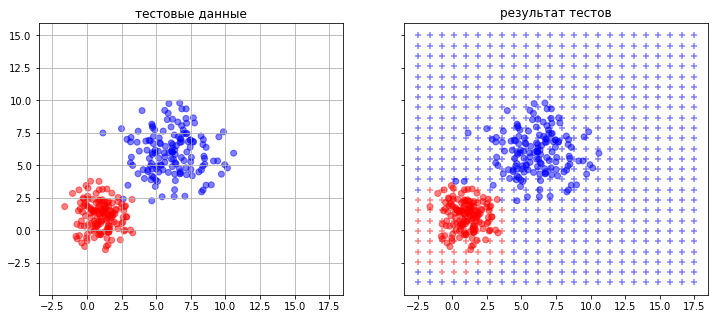

In [248]:
fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_test,y_test,'тестовые данные')    
plot_data(ax1,X_test,n_y_pred,'результат тестов')  
plot_data(ax1,X_grid,y_grid,'результат тестов', marker='+')    
plt.show()

In [200]:
def pbayes_score(X,Xl,yl,lmbd_n,h,n,Py_n,ly_n): # скор принадлежности X к классу n
    # Xl,yl - учебный набор
    # Py_n - априорная вероятность класса n
    # ly_n - количество объектов в классе n
    # lmbd_n - цена ошибки класса n
    # h - ширина парзеновского окна
    
    Xn = Xl[yl==n,:] # точки класса n
    
    m = Xn.shape[0]

    mkr = 1 / m * np.sum(Xn, axis = 0)
    print('mu' + str(n) + ' = ' + str(mkr))    
    skr = 1/(m-1) * np.dot((Xn - mkr).T, (Xn - mkr))
    print('sigma' + str(n) + ' = ' + str(skr))
    
    det_skr = np.linalg.det(skr)
    obr_skr = np.linalg.inv(skr)


    N = 1 / np.sqrt((2 * np.pi) ** 2 *  det_skr) * np.exp(-0.5 * np.dot((X - mkr), np.dot(obr_skr, (X - mkr).T)))
    N = N.sum(axis=0)

    return ( Py_n * lmbd_n ) * N

In [201]:
def pbayes(X,Xl,yl,lmbd,h): # байесовский классификатор
    # для кажной точки набора X 
    # хаходим номер класса с наибольшим скором
    # Xl,yl - учебный набор
    # lmbd - цена ошибки классов    
    # h - ширина окна
    
    # количество объектов в классах
    ly = np.asarray([ (yl==c).sum() for c in sorted(set(yl)) ])
    Py = ly/ly.sum() # априорные вероятности классов
    
    return np.argmax( 
        np.asarray([ 
            pbayes_score(X,Xl,yl,lmbd[n],h,n,Py[n],ly[n])  
            for n in sorted(set(yl)) 
        ]),
        axis=0 )

In [202]:
pp = pbayes(X_test,X_train,y_train,lmbd,h)
pp.shape

mu0 = [0.93637286 1.05100971]
sigma0 = [[ 1.08624067 -0.00226959]
 [-0.00226959  0.94798537]]
mu1 = [5.74623318 5.93544465]
sigma1 = [[ 3.08934274 -0.05996722]
 [-0.05996722  2.40590377]]


(300,)

In [203]:
# Махалонобиса метрика
def mah(x1, x2, obr_sigma): 
    return np.dot((x1 - x2), np.dot(obr_sigma, (x1 - x2).T))

def mah_score(x, mu, obr_sigma):
#     obr_sigma = np.linalg.inv(sigma)
    p = np.zeros(x.shape[0])
    for i in range(p.shape[0]):
        p[i] = (mah(x[i], mu, obr_sigma))
    return p

In [204]:
X = np.array([[1, 2], [5, 3], [4, 2]])
Y = np.array([[6, 5], [4, 3]])
s = np.array([[3, 0.2], [0.1, 2.9]])
obr_s = np.linalg.inv(s)
mah(X[1], X[2], obr_s)

0.6451612903225805

In [205]:
mah(X[0], X, obr_s)

array([[0.        , 0.        , 0.        ],
       [0.        , 5.55299539, 3.97465438],
       [0.        , 3.94009217, 3.00691244]])

In [206]:
np.asarray([rho(X[i], Y) for i in range(X.shape[0])])

array([[5.83095189, 3.16227766],
       [2.23606798, 1.        ],
       [3.60555128, 1.        ]])

In [207]:
np.asarray([mah(X[i], X, obr_s) for i in range(X.shape[0])]).shape

(3, 3, 3)

In [208]:
for i in range(X.shape[0]):
    for j in range(Y.shape[0]):
        print(i, j)
        print(mah(X[i], Y[j], obr_s))

0 0
10.944700460829491
0 1
3.248847926267281
1 0
1.6474654377880182
1 1
0.3341013824884792
2 0
4.23963133640553
2 1
0.3456221198156682


In [209]:
mah_score(X, Y, obr_s)

ValueError: setting an array element with a sequence.

In [210]:
mu = np.array([1, 1])
mah_score(X, mu, obr_s)

array([0.34562212, 6.4516129 , 3.24884793])

In [211]:

class MyPluginNaiveBayes:
    
    def __init__(self):
        self.mkr = []
        self.skr = []
        self.det_skr = []
        self.obr_skr = []
        self.yl = []
        pass
    
    def fit(self, X_train, y_train, lmbd):
        self.yl = sorted(set(y_train))
        self.lmbd = lmbd
        # количество объектов в классах
        self.ly = np.asarray([(y_train==c).sum() for c in self.yl])
        # априорные вероятности классов
        self.Py = self.ly / self.ly.sum() 
        for n in self.yl:
            Xn = X_train[y_train==n,:] # точки класса n
            m = Xn.shape[0]
            
            mkr = 1 / m * np.sum(Xn, axis = 0)
            self.mkr.append(mkr)
            skr = 1/(m-1) * np.dot((Xn - mkr).T, (Xn - mkr))
            self.skr.append(skr)
            
            det_skr = np.linalg.det(skr)
            self.det_skr.append(det_skr)
            obr_skr = np.linalg.inv(skr)
            self.obr_skr.append(obr_skr)
        return self
    
    def predict(self, X_test):
        res = []
        for n in self.yl:
#             Xm = np.abs(X_test - self.mkr[n])
            N = 1 / ((2 * np.pi) ** 2 * self.det_skr[n])** 0.5 * \
                np.exp(-0.5 * np.asarray(mah_score(X_test, self.mkr[n], self.obr_skr[n])))
#                 np.exp(-0.5 * mah_score(Xm, self.X_train, self.obr_skr[n]))
#             N = N.sum(axis=1)
            res.append(self.Py[n] * self.lmbd[n] * N)
        return np.argmax(np.asarray(res), axis=0)
            

In [212]:
clf = MyPluginNaiveBayes().fit(X_train, y_train, lmbd)
print('mu:\n' + str(clf.mkr))
print('sigma:\n' + str(clf.skr))
p_y_pred = clf.predict(X_test)

mu:
[array([0.93637286, 1.05100971]), array([5.74623318, 5.93544465])]
sigma:
[array([[ 1.08624067, -0.00226959],
       [-0.00226959,  0.94798537]]), array([[ 3.08934274, -0.05996722],
       [-0.05996722,  2.40590377]])]


In [213]:
y_grid = clf.predict(X_grid)

In [214]:
# y_grid = pbayes(X_grid, X_train, y_train, lmbd, h)

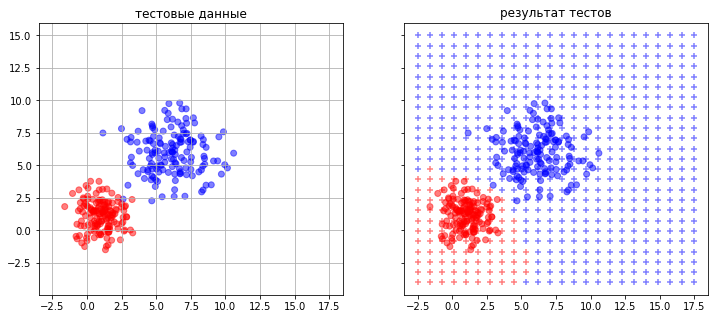

In [215]:
fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_test,y_test,'тестовые данные')    
plot_data(ax1,X_test,p_y_pred,'результат тестов')  
plot_data(ax1,X_grid,y_grid,'результат тестов', marker='+')    
plt.show()

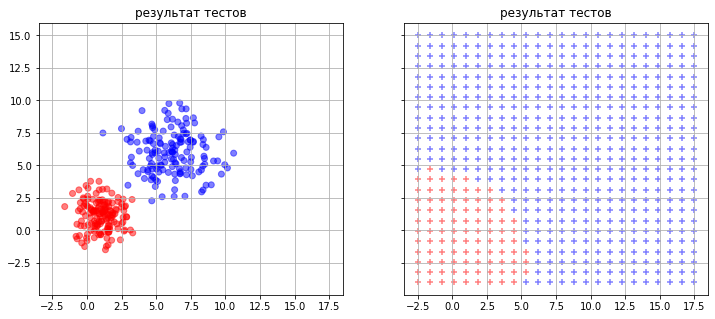

In [216]:
fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_test,p_y_pred,'результат тестов') 
plot_data(ax1,X_grid,y_grid,'результат тестов', marker='+')    
plt.show()